<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Classifiez automatiquement des biens de consommation
    Projet 6 Notebook image_faisabilite</h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

<a name="top"></a>

# Sommaire :

**Partie 1**

 - <a href="#C1"> 1.1 Importation des librairies</a>
 - <a href="#C2"> 1.2 Importation des données et les fonctions</a>
 
**Partie 2 :  Etude de faisabilité**
 - <a href="#C3"> Etude de faisabilité </a>
 - <a href="#C4"> 2.1 Etude de faisabilité avec SIFT</a>
 - <a href="#C5"> 2.2 Etude de faisabilité avec VGG16</a>

In [1]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p6/new'

# <a name="C1"> 1.1 Importation des librairies</a>
<a href="#top">sommaire</a>

In [2]:
from os import listdir
# Importation des libraries
import sys
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import warnings
warnings.filterwarnings("ignore")


Num GPUs Available:  1


In [3]:
# Les options pour visualisations des dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
#pd.set_option('display.max_rows', 200)

In [4]:
df_clean = pd.read_csv("df_clean.csv")
df_clean.head(1)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   

           category  \
0  Home Furnishing    

                                                                                       description_bow  \
0  key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance ...   

                                                                                   description_bow_lem  \
0  key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...   

                                                                                        description_dl  \
0  key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , eleg...   

   length_bow  length_dl  label_category  
0         156        248               4

In [5]:
test = df_clean.copy()

# <a name="C2"> 1.2 Importation des données </a>
<a href="#top">sommaire</a>

# Préparation du dataset

In [6]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/Images/"
list_photos =  test['image'].values.tolist()
print(len(list_photos))

1050


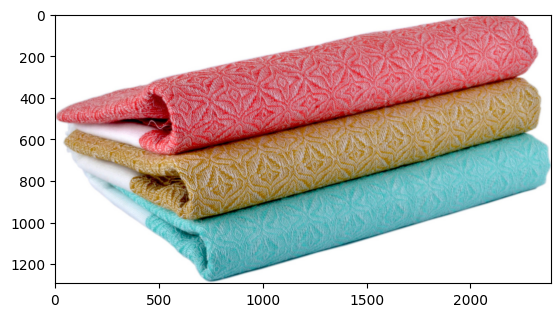

In [7]:
image = imread(path+list_photos[1])
plt.imshow(image)

## Import du dataset

In [8]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/Images/"
#list_photos = [file for file in listdir(path)]
list_photos =  test['image'].values.tolist()
print(len(list_photos))

1050


## Création dataframe pour nos analyses

In [9]:
data = pd.DataFrame()
data["image_path"] = list_photos
data["label_name"] = test["category"]
data["label"] = test["label_category"]
data

image_path        label_name  label
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing       4
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care       0
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care       0
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing       4
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing       4
...                                    ...               ...    ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care       0
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care       0
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care       0
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care       0
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care       0

[1050 rows x 3 columns]

In [10]:
data.groupby("label").count()

image_path  label_name
label                        
0             150         150
1             150         150
2             150         150
3             150         150
4             150         150
5             150         150
6             150         150

In [11]:
def countplot0(df, col):
    df_ranked = df[col].value_counts().reset_index()
    df_ranked.columns = [col, 'Count']
    df_ranked = df_ranked.sort_values('Count', ascending=False)
    sns.barplot(x='Count', y=col, data=df_ranked, orient='h')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.title("Répartition du " + col)
    plt.show()

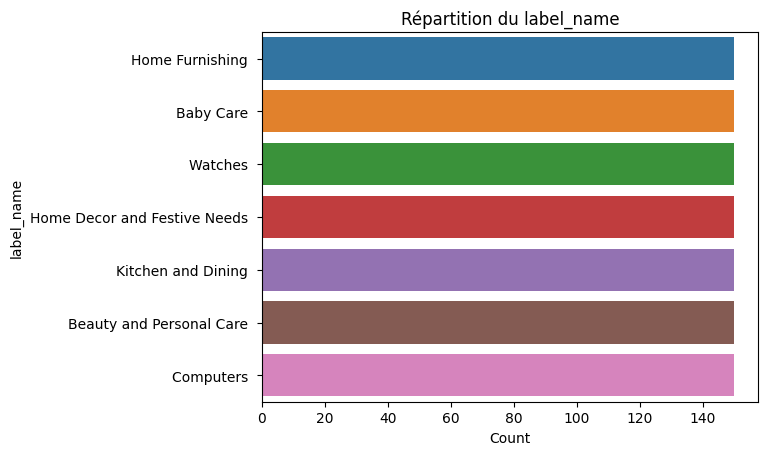

In [12]:
countplot0(data, "label_name")

On a des classes équilibrées.

## Exemples d'images par catégorie

In [13]:
test.category.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor and Festive Needs ', 'Kitchen and Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

Home Furnishing 


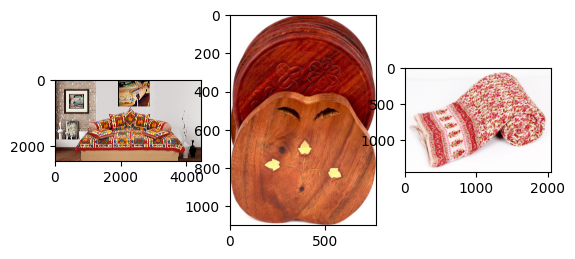

Baby Care 


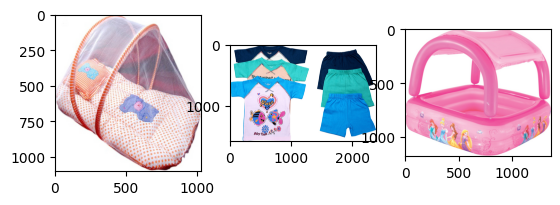

Watches 


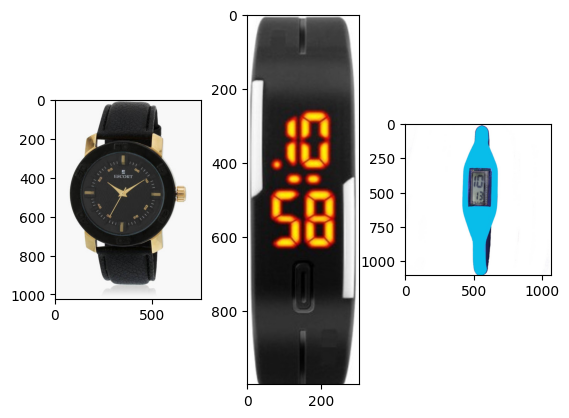

Home Decor and Festive Needs 


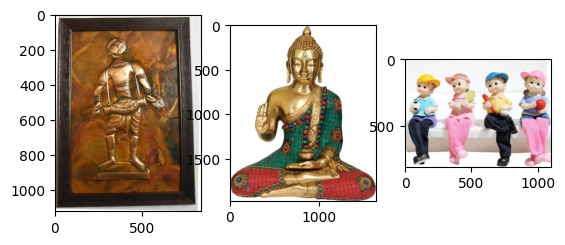

Kitchen and Dining 


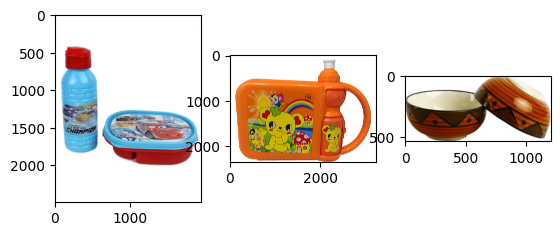

Beauty and Personal Care 


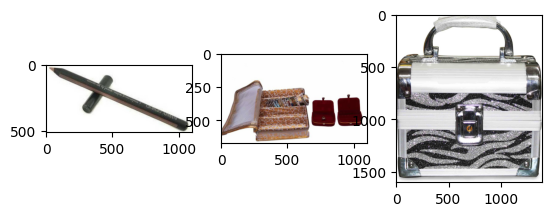

Computers 


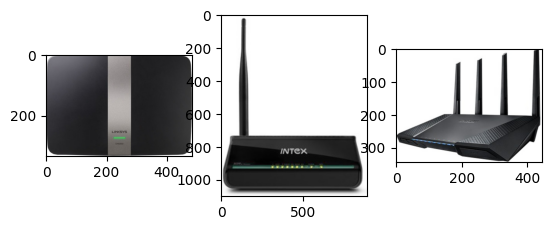

In [14]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_home = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Furnishing "]
list_baby = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Baby Care "]
list_watches = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Watches "]
list_decor = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Decor and Festive Needs "]
list_kitchen = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Kitchen and Dining "]
list_beauty = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Beauty and Personal Care "]
list_pc = [list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Computers "]

list_labels = test.category.unique()
for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# <a name="C3"> Etape 1 : Etude de faisabilité </a>
<a href="#top">sommaire</a>

# <a name="C4"> 2.1 Etude de faisabilité avec SIFT </a>
<a href="#top">sommaire</a>

## Détermination et affichage des descripteurs SIFT

* L'image contient 208 descripteurs
* Chaque descripteur est un vecteur de longueur 128

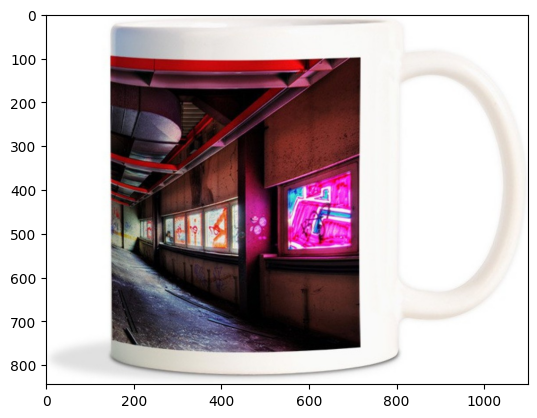

In [15]:
image_original = imread(path+list_photos[130])
plt.imshow(image_original)

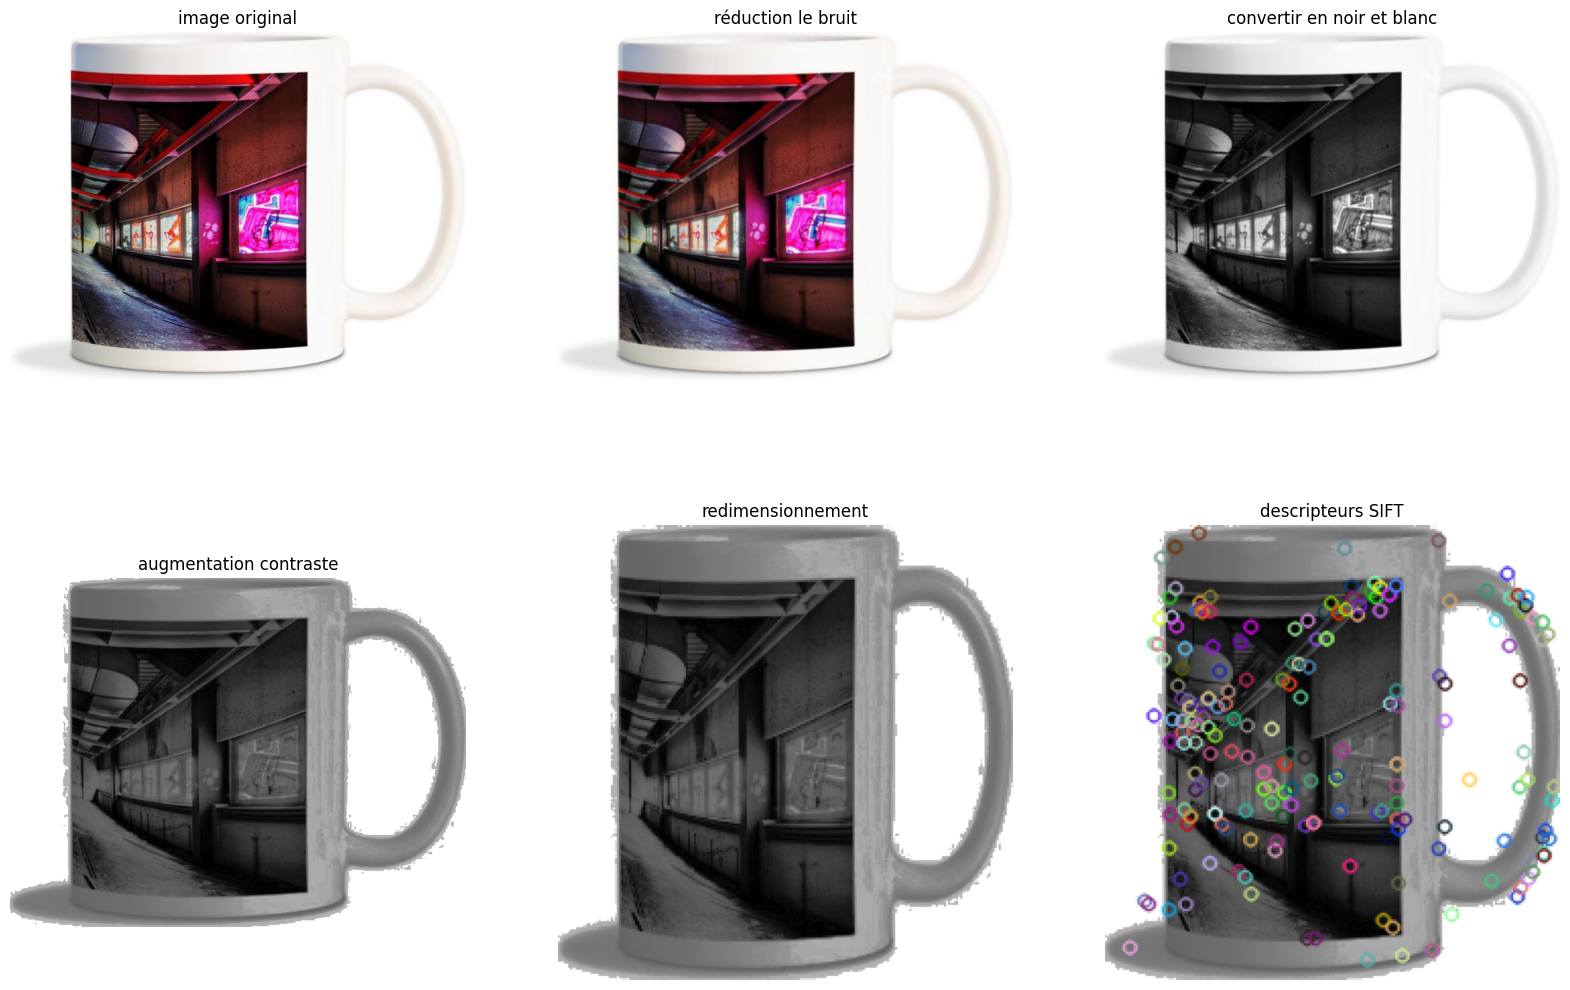

In [16]:
import cv2
sift = cv2.SIFT_create()
image = imread(path + list_photos[130]) # image depart


plt.figure(figsize=(20, 13))

plt.subplot(2,3,1)
plt.axis('off')
plt.title('image original')
plt.imshow(image)

plt.subplot(2,3,2)
# réduction le bruit 
image = cv2.GaussianBlur(image, (5, 5), 0)
plt.axis('off')
plt.title('réduction le bruit')
plt.imshow(image)

# convertir en noir et blanc
plt.subplot(2,3,3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.title('convertir en noir et blanc')
plt.imshow(image,cmap='gray')

# augmentation du contraste par égalisation du histogram
plt.subplot(2,3,4)
image = cv2.equalizeHist(image)   # equalize image histogram
plt.axis('off')
plt.title('augmentation contraste')
plt.imshow(image, cmap='gray')

# on redimensionne la taille
plt.subplot(2,3,5)
dsize = (224, 224)
image = cv2.resize(image, dsize)
plt.axis('off')
plt.title('redimensionnement')
plt.imshow(image, cmap='gray')

# detection des features SIFT
plt.subplot(2,3,6)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.axis('off')
plt.title('descripteurs SIFT')
plt.imshow(img)

plt.show()


In [17]:
# Print the shape of descriptors
print("Descripteurs : ", des.shape)
print()
print(des)

Descripteurs :  (208, 128)

[[ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  6. 27. ...  0.  0.  0.]
 [ 0. 11. 47. ...  0.  0.  0.]
 ...
 [56.  5.  0. ...  0.  0.  2.]
 [78.  6.  0. ...  0.  0. 21.]
 [79.  6.  0. ...  0.  0. 13.]]


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image réduction le bruit, passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [18]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path + list_photos[image_num])
    image = cv2.GaussianBlur(image, (5, 5), 0) # réduction le bruit
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convertir en noir et blanc
    rimage = cv2.equalizeHist(image) # equalize image histogram
    dsize = (224, 224)
    res = cv2.resize(image, dsize)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (510371, 128)
temps de traitement SIFT descriptor :           179.01 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [19]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  714
Création de 714 clusters de descripteurs ...
temps de traitement kmeans :             4.46 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [20]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.16 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [21]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 714)
Dimensions dataset après réduction PCA :  (1050, 495)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [22]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = test["category"]
print(df_tsne.shape)


(1050, 3)


In [23]:
df_tsne.head()

tsne1      tsne2             class
0  27.677794   0.358832  Home Furnishing 
1  25.533127  -4.833775        Baby Care 
2  -2.547703 -22.587191        Baby Care 
3  23.401854  -3.813202  Home Furnishing 
4  24.337646   1.558327  Home Furnishing

## Analyse visuelle : affichage T-SNE selon catégories d'images
* La méthode SIFT n'est pas efficace.

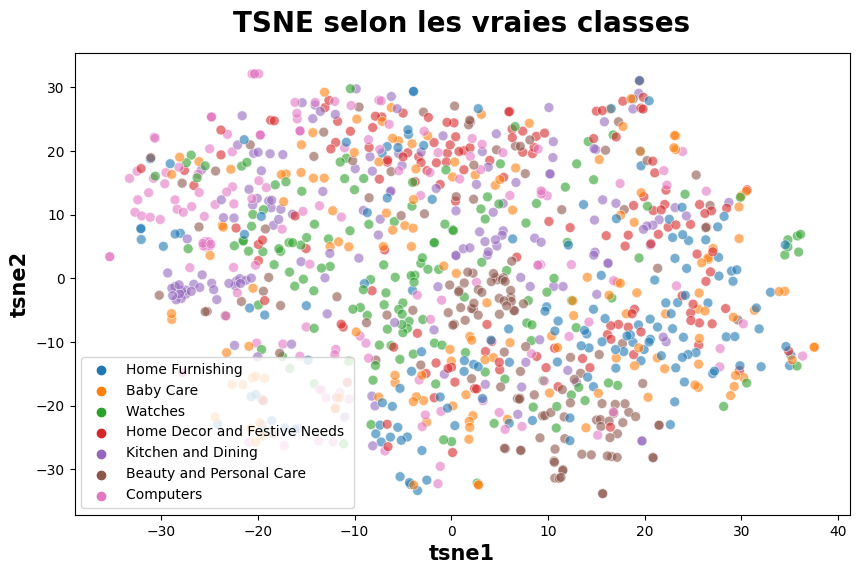

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 10}) 
plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [25]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


In [26]:
df_tsne.head()

tsne1      tsne2             class  cluster
0  27.677794   0.358832  Home Furnishing         0
1  25.533127  -4.833775        Baby Care         0
2  -2.547703 -22.587191        Baby Care         4
3  23.401854  -3.813202  Home Furnishing         0
4  24.337646   1.558327  Home Furnishing         0

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.05 est très faible

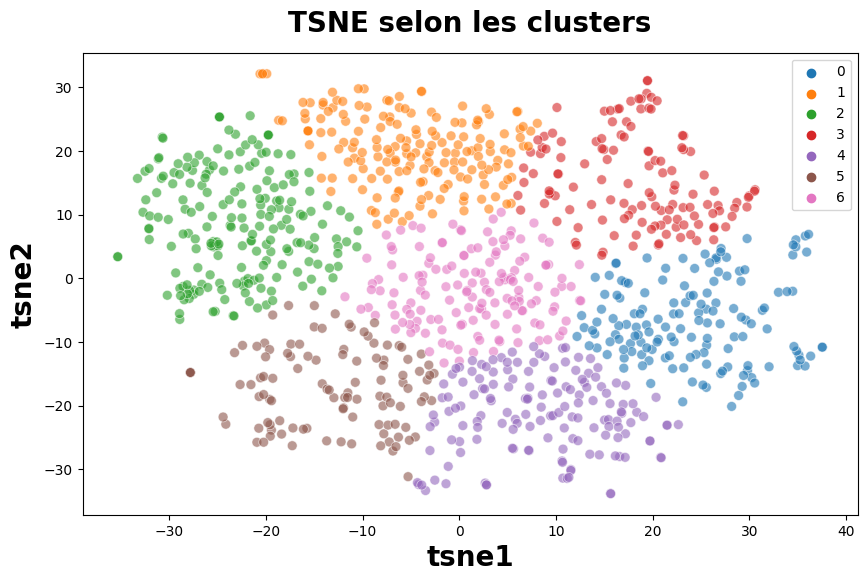

ARI :  0.05855030313184501


In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 20, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 10}) 
plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les catégories donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax"

In [28]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    145
1    173
2    197
3    127
4    150
5    109
6    149
Name: class, dtype: int64

In [29]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[36 24 18 17 18 22 15]
 [ 5 19 13 12 56  7 38]
 [ 8 30 56 11 13 24  8]
 [23 44 12 37 16 10  8]
 [56 13 12 16 22 21 10]
 [ 5 27 50 24  9 10 25]
 [12 16 36 10 16 15 45]]


In [30]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 3, 2, 5, 1, 0, 6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [31]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4, 3, 2, 5, 1, 0, 6]
[[22 18 18 24 36 17 15]
 [ 7 56 13 19  5 12 38]
 [24 13 56 30  8 11  8]
 [10 16 12 44 23 37  8]
 [21 22 12 13 56 16 10]
 [10  9 50 27  5 24 25]
 [15 16 36 16 12 10 45]]

              precision    recall  f1-score   support

           0       0.20      0.15      0.17       150
           1       0.37      0.37      0.37       150
           2       0.28      0.37      0.32       150
           3       0.25      0.29      0.27       150
           4       0.39      0.37      0.38       150
           5       0.19      0.16      0.17       150
           6       0.30      0.30      0.30       150

    accuracy                           0.29      1050
   macro avg       0.28      0.29      0.28      1050
weighted avg       0.28      0.29      0.28      1050



<Axes: >

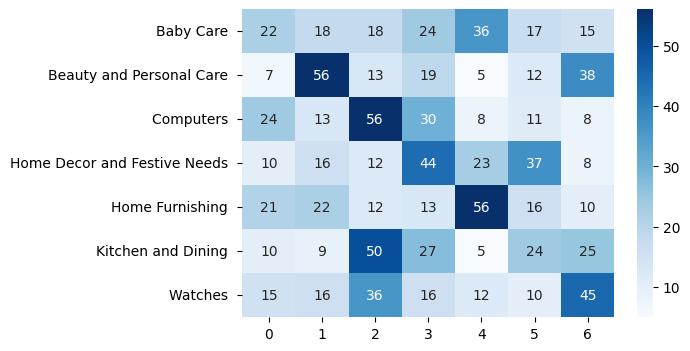

In [32]:
df_cm = pd.DataFrame(conf_mat, index = ['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
                                        'Home Decor and Festive Needs ', 'Home Furnishing ',
                                        'Kitchen and Dining ', 'Watches '],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### La méthode SIFT n'est pas efficace.

# <a name="C5"> 2.2 Etude de faisabilité avec VGG16 </a>
<a href="#top">sommaire</a>

## Création du modèle pré-entraîné

In [33]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [34]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path + image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


2023-08-23 22:25:29.854672: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [35]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 197)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [36]:
temps1 = time.time()
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             3.03 secondes


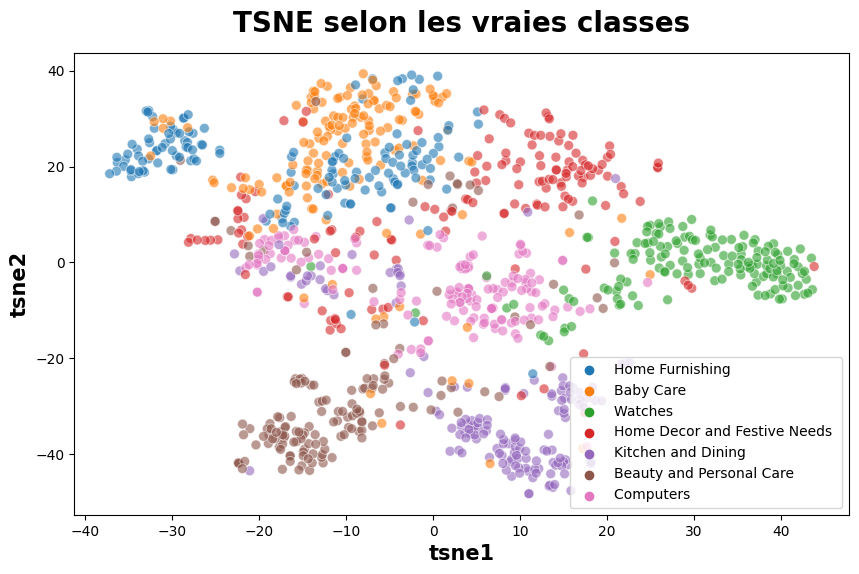

In [37]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [38]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100, random_state=100)

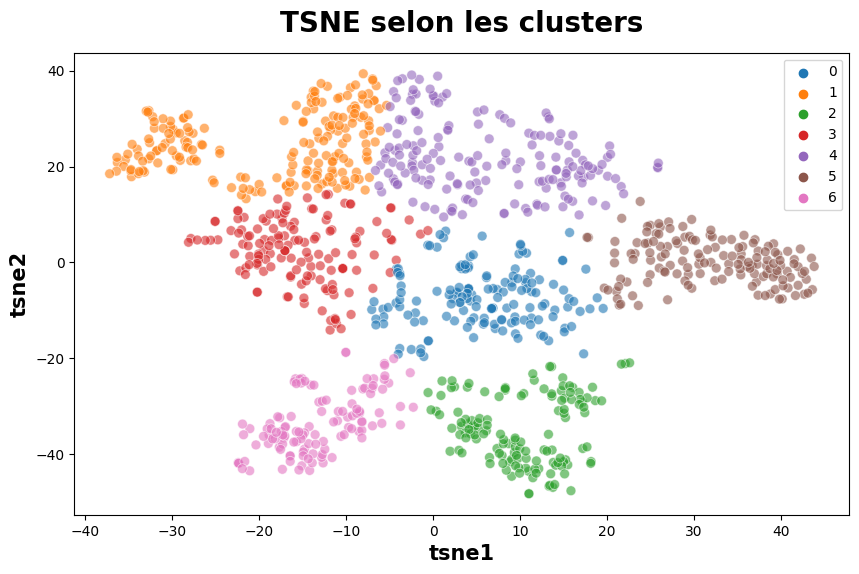

ARI :  0.4701232591720137


In [39]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 20, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [40]:
# Analyse d'image "Kitchen and Dining" affectées au cluster 6 "Beauty and Personal Care"

list_error_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Kitchen and Dining ') and (df_tsne.iloc[i]['cluster']==6)]
list_error_0[0]

72

tsne1               -21.070608
tsne2               -43.502693
class      Kitchen and Dining 
cluster                      6
Name: 72, dtype: object


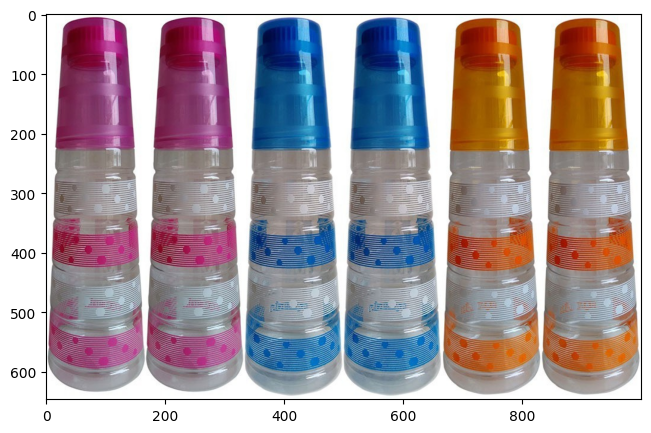

In [41]:
# Affichage image "Kitchen and Dining" considérée comme "Beauty and Personal Care"
id = 72
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = path + data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

* Analyse : Le modèle pré-entraîné confond les bocaux d'épices avec des produits de manucure.

### Analyse par classes

In [42]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    149
1    191
2    136
3    140
4    171
5    145
6    118
Name: class, dtype: int64

In [43]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  5  97   4  12  28   2   2]
 [  9   2   8   9   9   1 112]
 [105   0   2  42   0   1   0]
 [  8   7   3  37  87   6   2]
 [  1  85   1  19  44   0   0]
 [  8   0 118  20   2   0   2]
 [ 13   0   0   1   1 135   0]]


In [44]:
def conf_mat_transform_1(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    corresp = [2, 0, 5, 4, 3, 6, 1]
    #corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [45]:
cls_labels_transform = conf_mat_transform_1(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2, 0, 5, 4, 3, 6, 1]
[[ 97   2   5  28  12   4   2]
 [  2 112   9   9   9   8   1]
 [  0   0 105   0  42   2   1]
 [  7   2   8  87  37   3   6]
 [ 85   0   1  44  19   1   0]
 [  0   2   8   2  20 118   0]
 [  0   0  13   1   1   0 135]]

              precision    recall  f1-score   support

           0       0.51      0.65      0.57       150
           1       0.95      0.75      0.84       150
           2       0.70      0.70      0.70       150
           3       0.51      0.58      0.54       150
           4       0.14      0.13      0.13       150
           5       0.87      0.79      0.83       150
           6       0.93      0.90      0.92       150

    accuracy                           0.64      1050
   macro avg       0.66      0.64      0.65      1050
weighted avg       0.66      0.64      0.65      1050



<Axes: >

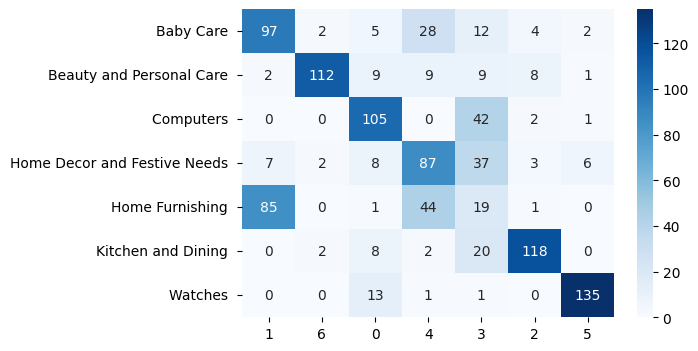

In [46]:
df_cm = pd.DataFrame(conf_mat, index = ['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
                                        'Home Decor and Festive Needs ', 'Home Furnishing ',
                                        'Kitchen and Dining ', 'Watches ']
,
                  columns = [i for i in "1604325"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')

* La classe la moins bien prédite est "Home Furnishing"